In [1]:
import math
import joblib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import qutip
from tqdm import tqdm

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
import entanglement_propagation
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar
from tools.plot import set_xlabel_as_pi_fraction

## Проверка гамильтониана $ \sum S^z_jS^z_{j+1} \sim 4 \sum n^a_{j}n^a_{j+1} $

In [4]:
n_jobs = 1

In [5]:
n_bosons = 5
model = bec.BEC_Qubits.init_default(n_bosons, 0)

m = 3
i_projection = n_bosons

print_model_info(model)

BEC_Qubits(n_bosons=5, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=False, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
init_state = (
    # np.prod([bec.coherent_state_constructor(model, n=m, k=i) for i in range(m)]) # 100x slowly
    math.prod(bec.coherent_state_constructor(model, n=m, k=i) for i in range(m))
    * bec.vacuum_state(model, n=m)
)

In [7]:
%time h_zz = sum(bec.sz(model, n=m, k=i) * bec.sz(model, n=m, k=i+1) for i in range(m - 1))

CPU times: user 29.3 ms, sys: 4.14 ms, total: 33.4 ms
Wall time: 32.8 ms


In [8]:
%time h_na = 4 * sum((-1)**i * bec.na(model, n=m, k=i) * bec.na(model, n=m, k=i+1) for i in range(m - 1))

CPU times: user 15.2 ms, sys: 2.58 ms, total: 17.8 ms
Wall time: 16.5 ms


In [9]:
tspan = np.linspace(0, np.pi / 4, 301)

In [10]:
%time states_hzz_n2_teor = [bec.state_under_h_zz_teor(model, t / model.Omega) for t in tqdm(tspan)]

100%|██████████| 301/301 [00:02<00:00, 123.67it/s]

CPU times: user 2.41 s, sys: 41.6 ms, total: 2.46 s
Wall time: 2.44 s


In [11]:
states_hzz_n3 = qutip.sesolve(
    h_zz, init_state, tspan, progress_bar=TqdmProgressBar()
).states

/Users/kephircheek/venvs/science/emqwuqoc-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 301/301 [00:03<00:00, 81.14it/s]


In [12]:
states_hna_n3 = qutip.sesolve(
    h_na, init_state, tspan, progress_bar=TqdmProgressBar()
).states

100%|██████████| 301/301 [00:03<00:00, 76.33it/s]


Редукция вместо измерения

In [13]:
states_hzz_n3_reduced = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda x: qutip.ptrace(x, [0, 1, m * 2 - 2, m * 2 - 1]))(s)
    for s in tqdm(states_hzz_n3)
)

100%|██████████| 301/301 [00:07<00:00, 38.99it/s]


Создаем проектор для измерения и проводим измерение

In [14]:
# measure_x = bec.fock_x_state_constructor(model, n=m, i=1, k=i_projection) #* bec.vacuum_state(model, n=n)
# measure_x_op = mesuare_x * mesuare_x.dag()


def measure(state):
    measure_x = bec.fock_x_state_constructor(
        model, n=m, i=1, k=i_projection
    )  # * bec.vacuum_state(model, n=n)
    measure_x_op = measure_x * measure_x.dag()

    dim = len(states_hzz_n3[0].dims[0])
    # print(measure_x_op)
    # print(measure_x_op.copy() * state)
    state_measure_unnormalized = qutip.ptrace(
        measure_x_op * state, [0, 1, dim - 2, dim - 1]
    )
    return state_measure_unnormalized / state_measure_unnormalized.tr()

In [15]:
states_hzz_n3_mesuared_by_x = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(measure)(s) for s in tqdm(states_hzz_n3)
)

100%|██████████| 301/301 [00:14<00:00, 21.04it/s]


In [16]:
states_hna_n3_mesuared_by_x = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(measure)(s) for s in tqdm(states_hna_n3)
)

100%|██████████| 301/301 [00:14<00:00, 21.25it/s]


### Энтропия 

In [17]:
entropy_hzz_n2_teor = [
    qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2)
    for s in tqdm(states_hzz_n2_teor)
]
entropy_hzz_n3 = [
    qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2)
    for s in tqdm(states_hzz_n3_reduced)
]
entropy_hzz_n3_x = [
    entanglement_propagation.entropy_vn(qutip.ptrace(s, [0, 1]), base=2)
    for s in tqdm(states_hzz_n3_mesuared_by_x)
]
entropy_hna_n3_x = [
    entanglement_propagation.entropy_vn(qutip.ptrace(s, [0, 1]), base=2)
    for s in tqdm(states_hna_n3_mesuared_by_x)
]

100%|██████████| 301/301 [00:00<00:00, 729.89it/s]


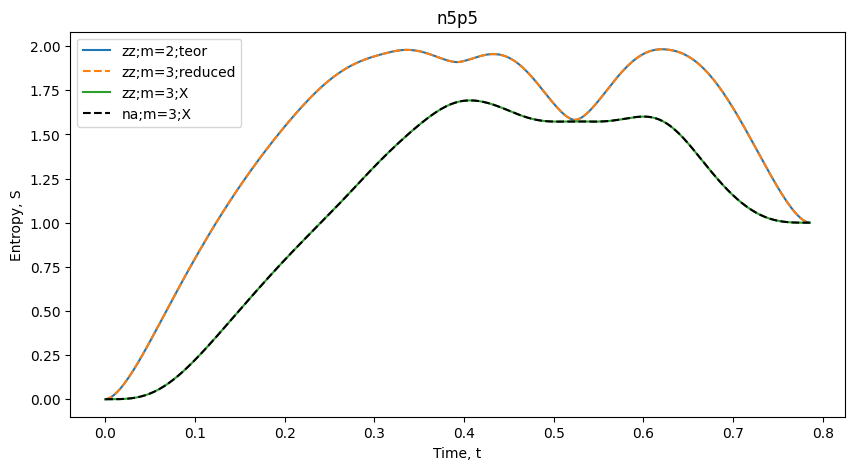

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, entropy_hzz_n2_teor, label=f"zz;m=2;teor")
ax.plot(tspan, entropy_hzz_n3, "--", label=f"zz;m={m};reduced")
ax.plot(tspan, entropy_hzz_n3_x, "-", label=f"zz;m={m};X")
ax.plot(tspan, entropy_hna_n3_x, "--k", label=f"na;m={m};X")

ax.set_title(f"n{n_bosons}p{i_projection}")
ax.set_ylabel("Entropy, S")
ax.set_xlabel("Time, t")
ax.legend()

Энтропия действительно совпадает 

### Фиделити

In [19]:
fids_hzz_n3_reduced = [
    qutip.metrics.fidelity(a, b)
    for a, b in tqdm(
        zip(states_hzz_n2_teor, states_hzz_n3_reduced), total=len(states_hzz_n2_teor)
    )
]

100%|██████████| 301/301 [00:06<00:00, 45.57it/s]


In [20]:
fids_hzz_n3_mesuared_by_x = [
    qutip.metrics.fidelity(a, b)
    for a, b in tqdm(
        zip(states_hzz_n2_teor, states_hzz_n3_mesuared_by_x),
        total=len(states_hzz_n2_teor),
    )
]

100%|██████████| 301/301 [00:06<00:00, 45.53it/s]


In [21]:
fids_hna_n3_mesuared_by_x = [
    qutip.metrics.fidelity(a, b)
    for a, b in tqdm(
        zip(states_hzz_n2_teor, states_hna_n3_mesuared_by_x),
        total=len(states_hzz_n2_teor),
    )
]

100%|██████████| 301/301 [00:06<00:00, 45.56it/s]


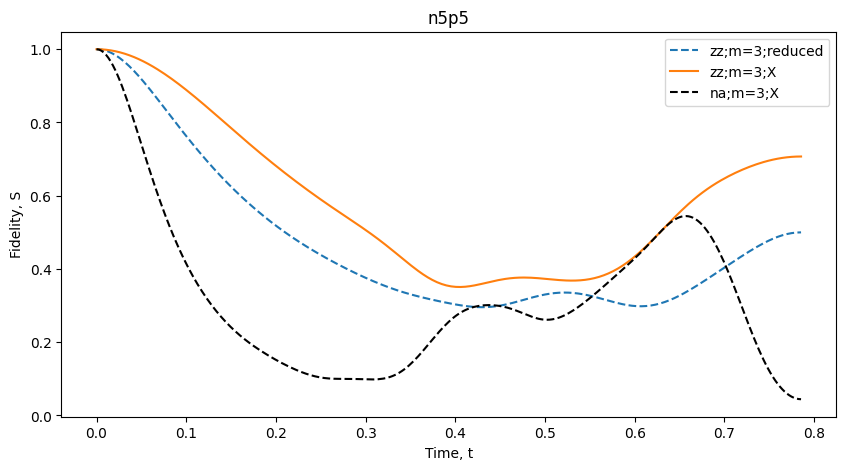

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fids_hzz_n3_reduced, "--", label=f"zz;m={m};reduced")
ax.plot(tspan, fids_hzz_n3_mesuared_by_x, "-", label=f"zz;m={m};X")
ax.plot(tspan, fids_hna_n3_mesuared_by_x, "--k", label=f"na;m={m};X")

ax.set_title(f"n{n_bosons}p{i_projection}")
ax.set_ylabel("Fidelity, S")
ax.set_xlabel("Time, t")
ax.legend()

### График фиделити на основе аналитических рассчетов

In [23]:
q = [i_projection]

In [24]:
f_state_span = [
    (s := entanglement_propagation.f_state(4 * t, q, m, n_bosons)) / s.norm()
    for t in tqdm(tspan)
]

100%|██████████| 301/301 [00:01<00:00, 196.89it/s]


In [25]:
f_state_entropy = [
    qutip.entropy.entropy_vn(qutip.ptrace(s, [0]), base=2) for s in tqdm(f_state_span)
]

100%|██████████| 301/301 [00:00<00:00, 7123.79it/s]


In [26]:
state_hzz_n2_teor_span = [
    bec.state_under_h_zz_teor_focked(model, t / model.Omega) for t in tqdm(tspan)
]
state_hzz_n2_teor_entropy_span = [
    qutip.entropy.entropy_vn(qutip.ptrace(s, [0]), base=2)
    for s in tqdm(state_hzz_n2_teor_span)
]

100%|██████████| 301/301 [00:00<00:00, 6417.06it/s]


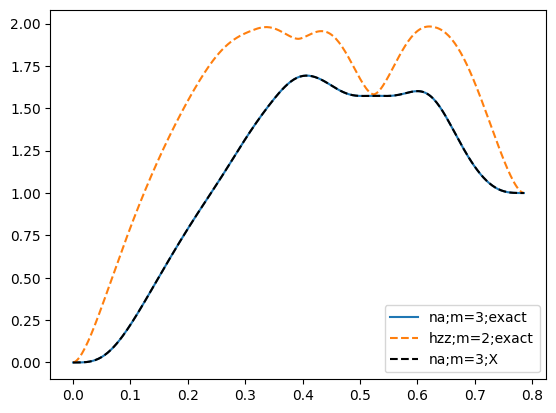

In [27]:
_, ax = plt.subplots(1, 1)
ax.plot(tspan, f_state_entropy, label=f"na;m={m};exact")
ax.plot(tspan, state_hzz_n2_teor_entropy_span, "--", label=f"hzz;m={2};exact")
ax.plot(tspan, entropy_hna_n3_x, "--k", label=f"na;m={m};X")
ax.legend()

In [28]:
f_state_fid = [
    qutip.metrics.fidelity(s, s_)
    for s, s_ in tqdm(zip(f_state_span, state_hzz_n2_teor_span))
]

301it [00:00, 360916.38it/s]


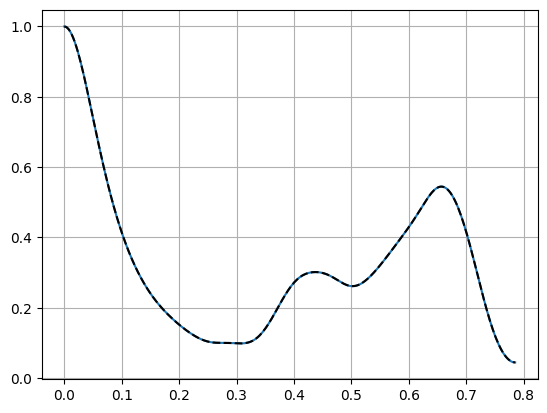

In [29]:
_, ax = plt.subplots(1, 1)
ax.plot(tspan, f_state_fid)
ax.plot(tspan, fids_hna_n3_mesuared_by_x, "--k", label=f"na;m={m};X")
ax.grid()

In [30]:
f_state_reduced_fid = [
    qutip.metrics.fidelity(qutip.ptrace(s, [0]), qutip.ptrace(s_, [0]))
    for s, s_ in tqdm(zip(f_state_span, state_hzz_n2_teor_span))
]

301it [00:00, 1929.93it/s]


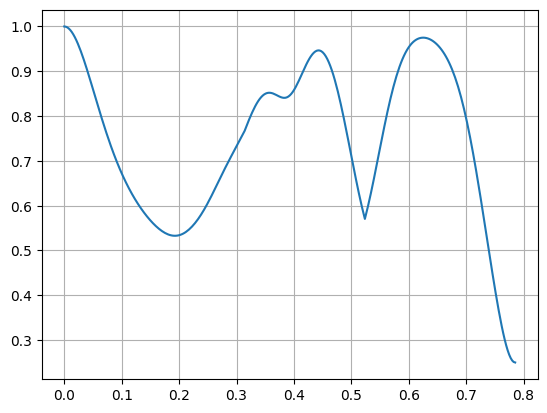

In [31]:
_, ax = plt.subplots(1, 1)
ax.plot(tspan, f_state_reduced_fid)
ax.grid()

## Сравнение цепочкек разной длины

In [32]:
tspan = np.linspace(0, np.pi, 251)
n_ = 10


def f_state(t, q, m_, n_):
    s = entanglement_propagation.f_state(t, q, m_, n_)
    s /= s.norm() or 1
    return s


f_state_span_by_m = {}

for m_ in range(3, 8):
    q = [n_ for _ in range(m_ - 2)]
    f_state_span = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(f_state)(t, q, m_, n_) for t in tqdm(tspan, postfix=f"m={m_}")
    )
    f_state_span_by_m[m_] = f_state_span

100%|██████████| 251/251 [02:04<00:00,  2.01it/s, m=7]


In [33]:
for m_, f_state_span in f_state_span_by_m.items():
    qutip.qsave(f_state_span, f"../assets/timsway-f_state-m{m_}-n{n_}")

In [34]:
model = bec.BEC_Qubits.init_default(n_, 0)
h_zz_state_n2_exact_span = [
    bec.state_under_h_zz_teor_focked(model, t / model.Omega / 4) for t in tqdm(tspan)
]
h_nn_state_n2_exact_span = [
    bec.state_under_h_na_exact_focked(model, t) for t in tqdm(tspan)
]

100%|██████████| 251/251 [00:03<00:00, 80.06it/s]


### Фиделити между состояниями $H_{nn}$ и $H_{zz}$

100%|██████████| 251/251 [00:00<00:00, 38397.05it/s]


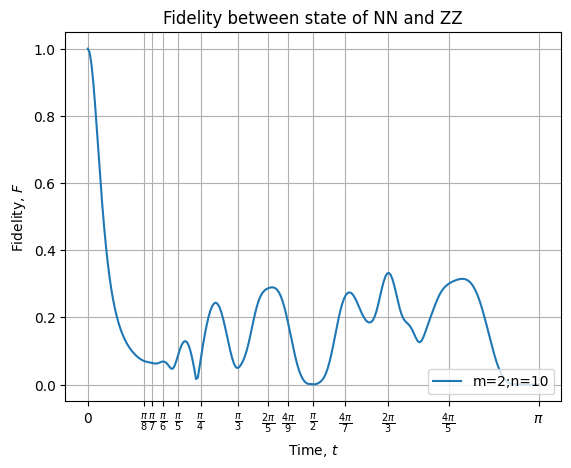

In [35]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Fidelity between state of NN and ZZ")

h_nn_state_fid = [
    qutip.metrics.fidelity(s, s_)
    for s, s_ in tqdm(
        zip(h_zz_state_n2_exact_span, h_nn_state_n2_exact_span),
        total=len(h_nn_state_n2_exact_span),
    )
]
ax.plot(tspan, h_nn_state_fid, label=f"m={2};n={n_}")

set_xlabel_as_pi_fraction(ax)
ax.set_ylabel(r"Fidelity, $F$")
ax.set_xlabel(r"Time, $t$")
ax.legend(loc="lower right")
ax.grid()

### Энтропия

100%|██████████| 251/251 [00:00<00:00, 6259.52it/s]


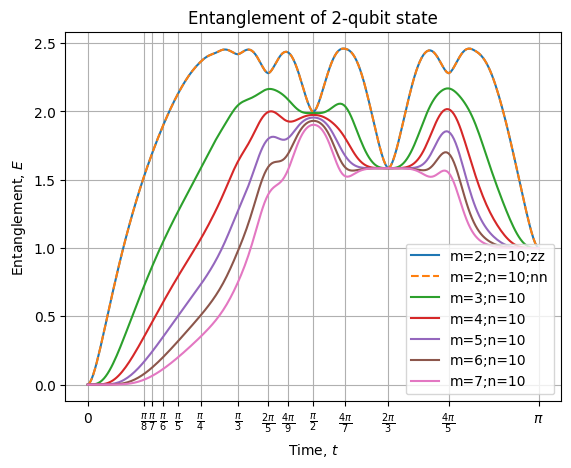

In [36]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Entanglement of 2-qubit state")

hzz_state_entropy = [
    qutip.entropy.entropy_vn(qutip.ptrace(s, [0]), base=2)
    for s in tqdm(h_zz_state_n2_exact_span)
]
ax.plot(tspan, hzz_state_entropy, label=f"m={2};n={n_};zz")

h_nn_state_entropy = [
    qutip.entropy.entropy_vn(qutip.ptrace(s, [0]), base=2)
    for s in tqdm(h_nn_state_n2_exact_span)
]
ax.plot(tspan, h_nn_state_entropy, "--", label=f"m={2};n={n_};nn")

for m_, f_state_span in f_state_span_by_m.items():
    f_state_entropy = [
        qutip.entropy.entropy_vn(qutip.ptrace(s, [0]), base=2)
        for s in tqdm(f_state_span)
    ]
    ax.plot(tspan, f_state_entropy, label=f"m={m_};n={n_}")

set_xlabel_as_pi_fraction(ax)
ax.set_xlabel(r"Time, $t$")
ax.set_ylabel(r"Entanglement, $E$")
ax.legend(loc="lower right")
ax.grid()

In [37]:
fig.tight_layout()
fig.savefig(f"../assets/timsway-entanglement-n{n_}.png")

### Фиделити между состояниями

100%|██████████| 251/251 [00:00<00:00, 218281.22it/s]


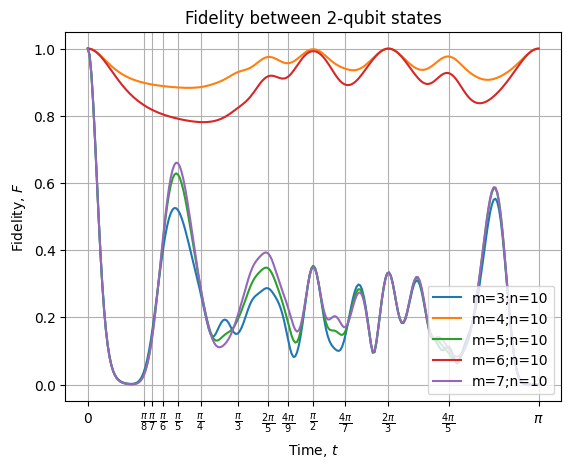

In [38]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Fidelity between 2-qubit states")

for m_, f_state_span in f_state_span_by_m.items():
    f_state_fid = [
        qutip.metrics.fidelity(s, s_)
        for s, s_ in tqdm(
            zip(f_state_span, h_nn_state_n2_exact_span),
            total=len(h_nn_state_n2_exact_span),
        )
    ]
    ax.plot(tspan, f_state_fid, label=f"m={m_};n={n_}")

set_xlabel_as_pi_fraction(ax)
ax.set_xlabel(r"Time, $t$")
ax.set_ylabel(r"Fidelity, $F$")
ax.legend(loc="lower right")
ax.grid()

In [39]:
fig.tight_layout()
fig.savefig(f"../assets/timsway-fidelity-n{n_}.png")

100%|██████████| 251/251 [00:00<00:00, 1709.51it/s]


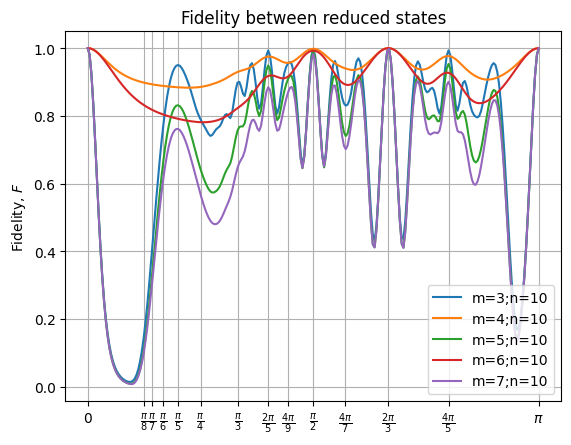

In [40]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Fidelity between reduced states")

for m_, f_state_span in f_state_span_by_m.items():
    f_state_reduced_fid = [
        qutip.metrics.fidelity(qutip.ptrace(s, [1]), qutip.ptrace(s_, [1]))
        for s, s_ in tqdm(
            zip(f_state_span, h_nn_state_n2_exact_span),
            total=len(h_nn_state_n2_exact_span),
        )
    ]
    ax.plot(tspan, f_state_reduced_fid, label=f"m={m_};n={n_}")


set_xlabel_as_pi_fraction(ax)
ax.set_ylabel(r"Fidelity, $F$")
ax.legend(loc="lower right")
ax.grid()

In [41]:
fig.tight_layout()
fig.savefig(f"../assets/timsway-reduced-fidelity-n{n_}.png")